<a href="https://colab.research.google.com/github/Kodhandarama/Audio_Analysis/blob/master/tonic%2Bpitch_histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# connects colab to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Projects/AA/Code/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# #importing nessecary libraries
# import librosa
# import librosa.display
# import numpy as np
# import math
# import matplotlib.pyplot as plt
# from scipy.fftpack import *
# from scipy.signal import kaiserord, lfilter, firwin, freqz, spectrogram
# plt.rcParams['figure.figsize'] = [10, 5]
# freq_cqt = librosa.cqt_frequencies(90, fmin=32)
# from swipe import *
                                   

In [0]:
# importing nessecary libraries
import librosa
import librosa.display
from swipe import *

plt.rcParams['figure.figsize'] = [20,5]
# cqt bin frequencies
freq_cqt = librosa.cqt_frequencies(90, fmin=32)

ratios = {'Sa':1,'Ri1':16/15,'Ri2/Ga1':9/8,'Ga2/Ri3':6/5,'Ga3':5/4,'Ma1':4/3,'Ma2':17/12,'Pa':3/2,'Da1':8/5,
          'Da2/Ni1':5/3,'Ni2/Da3':9/5,'Ni3':15/8,'Sa2':2}
all_normalized_notes = dict()
for i,j in ratios.items():
  all_normalized_notes[i] = 12*np.log2(j)

In [0]:
import librosa
import librosa.display
from swipe import *
import math

plt.rcParams['figure.figsize'] = [20,5]
# defining the class 
# each object of this class is an audio clip that is to be analysed
class Audio:
  def __init__(self, path, sr=None, duration = None):
    # loading the audio file
    self.x, self.sr1 = librosa.load(path= path, sr=sr,duration=duration)
    self.pitch_contour()
    self.diff = np.diff(self.pitch)
    self.constant_pitch(with_n = False)
    #self.tonic = self.find_tonic()
    #self.constant_pitch(with_n = True)
    self.find_gamaka()
  # computing pitch contour
  def pitch_contour(self,dt = 0.01):
    self.pitch, self.time_axis, self.s = swipe(self.x,self.sr1,[100, 500],dt, 0.4)
    #self.pitch = self.pitch.round(decimals = 2)

  def constant_pitch(self,with_n ):
    
    time_axis_80 = []
    pitch_80 = []
    constant_pitch_time_80=[]
    
    # normalised pitch by 12*log(to the base 2) (f[i]/f0)
    # where f0 is the tonic 
    if(with_n):

      self.normalised_pitch=[]
      
      for i in self.pitch:
        self.normalised_pitch.append((12*np.log2(i/self.tonic)))
      
      for i in range(0,len(self.time_axis),8):
        pitch_80.append(self.normalised_pitch[i])
        time_axis_80.append(self.time_axis[i])
      # calculating the 1st order difference
      delta = 0.3

    else:

      for i in range(0,len(self.time_axis),8):
        pitch_80.append(self.pitch[i])
        time_axis_80.append(self.time_axis[i])
      delta = 12
      
    diff_80 = np.diff(pitch_80)

    for i in range(len(diff_80)):
      # constant note when the slope(of the pitch contour) is within the thershold i.e, delta =  
      if(diff_80[i]<delta/2 and diff_80[i]>-delta/2):
        constant_pitch_time_80.append(time_axis_80[i])
    #self.constant_pitch_notes = [(i,j) for i,j in all_normalized_notes.items() if j in self.cpn]
    self.constant_pitch_time_80 = np.array(constant_pitch_time_80)

    cpt = list(self.constant_pitch_time_80.round(2))
    tim = []
    initial = cpt[0]
    c= initial
    for i in range(1,len(cpt)):
      check = round(cpt[i]-c,2)
      if(check == 0.08):
        pass
      else:
        tim.append((initial,c))
        initial = cpt[i]
      if i == (len(cpt)-1):
        c= cpt[i]
        tim.append((initial,c))
      c= cpt[i]
    ta = list(self.time_axis)
    self.cpn_and_t = []
    for i in tim:
      begin = int(100*i[0])
      end = int(100*i[1])
      self.cpn_and_t.append((self.pitch[begin:end],ta[begin:end]))
    self.cpn_and_t = np.array(self.cpn_and_t)
    g,h = self.cpn_and_t.T
    self.cpn = [item for sublist in g for item in sublist]
    self.cpt = [item for sublist in h for item in sublist]
  
  def find_gamaka(self):
    self.gamaka = []
    diff_p = np.diff(self.pitch)
    for i in range(0,len(diff_p)):
      if abs(diff_p[i]>4) and self.pitch[i] not in self.cpn:
        self.gamaka.append([self.time_axis[i],self.pitch[i]])
    gamaka_T = np.array(self.gamaka)
    self.gamaka = gamaka_T.T



  def find_tonic(self):
    def most_frequent(List): 
      counter = 0
      num = List[0] 
        
      for i in List: 
          curr_frequency = List.count(i) 
          if(curr_frequency> counter): 
              counter = curr_frequency 
              num = i 
    
      return num

    store_tonic_pa=list()
    store_tonic_ri2=list()
    store_tonic_ma1=list()
    store_tonic_ga3=list()
    store_tonic_ni3=list()
    floored=[]
    toniclist=[]
    """
    uniquepitch=set(self.cpn)
    uniquepitchfloor=[]
    for i in uniquepitch:
      i=math.floor(i)
      uniquepitchfloor.append(i)
    """
    uniquepitchfloor = list(self.cpn)
    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.49) and ((i/j) <1.51)):
              store_tonic_pa.append(j)
            if(((i/j)>1.1) and ((i/j) <1.14) ):
              store_tonic_ri2.append(j)
    if(store_tonic_pa):
      pa_to_sa=most_frequent(store_tonic_pa)
      toniclist.append(pa_to_sa)
    else:
      toniclist.append(500)
    if(store_tonic_ri2):
      ri2_to_sa=most_frequent(store_tonic_ri2)
      toniclist.append(ri2_to_sa)
    else:
      toniclist.append(600)
    if(abs(toniclist[1]-toniclist[0])< 5):
      # print(toniclist[0])
      return toniclist[0]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            
            if(((i/j)>1.29) and ((i/j) <1.35) ):
            
              store_tonic_ma1.append(j)
    if(store_tonic_ma1):
      ma1_to_sa=most_frequent(store_tonic_ma1)
      toniclist.append(ma1_to_sa)
    else:
      toniclist.append(700)
    
    if((abs(toniclist[2]-toniclist[0])< 5) or (abs(toniclist[2]-toniclist[1])< 5)):
      # print(toniclist[2])
      return toniclist[2]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.2) and ((i/j) <1.27)):
              store_tonic_ga3.append(j)
    if(store_tonic_ga3):
      ga3_to_sa=most_frequent(store_tonic_ga3)
      toniclist.append(ga3_to_sa)
    else:
      toniclist.append(800)
    if((abs(toniclist[3]-toniclist[0])< 5) or (abs(toniclist[3]-toniclist[1])< 5) or (abs(toniclist[3]-toniclist[2])< 5)):
      # print(toniclist[3])
      return toniclist[3]

    for i in uniquepitchfloor:
      for j in uniquepitchfloor:
            if(((i/j)>1.85) and ((i/j) <1.9) ):
              
              store_tonic_ni3.append(j)
    if(store_tonic_ni3):
      ni3_to_sa=most_frequent(store_tonic_ni3)
      toniclist.append(ni3_to_sa)
    else:
      toniclist.append(900)   
    if((abs(toniclist[4]-toniclist[0])< 5) or (abs(toniclist[4]-toniclist[1])< 5) or (abs(toniclist[4]-toniclist[2])< 5) or (abs(toniclist[4]-toniclist[3])< 5)):
      print(toniclist[4])
      return toniclist[4]
    # print("tonic not found sigh")
    # print(toniclist[0])
    return toniclist[0] #lets just assume Pa was there
  def plot(self,**kwargs):
    for key,value in kwargs.items():
      if(key=='contour' and value):
        plt.plot(self.time_axis,self.pitch,label = 'Pitch Contour')
      if(key == 'cpn' and value):
        plt.plot(self.time_axis,self.pitch,c="#FF0000",label = 'Pitch Contour')
        plt.scatter(self.cpt,self.cpn,c='0',label = 'Constant Pitch')
      if(key == 'gamaka' and value):
        plt.scatter(self.gamaka[0],self.gamaka[1],c="#00FF00",label = 'Gamaka')

      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
  def develop_histogram():
    values=[x for x in self.pitch if (math.isnan(x) == False)]
    values=[round(x,0) for x in values]
    occur=dict()
    times=[]
    for i in values:
      if(i in occur):
        occur[i]+=1;
      else:
        occur[i]=1;
    j=50
    while(j<=1000):
      # print(j)
      if(j in occur):
        times.append(occur[j])
      else:
        times.append(0)
      j+=1
    self.histogram_occurances=times;


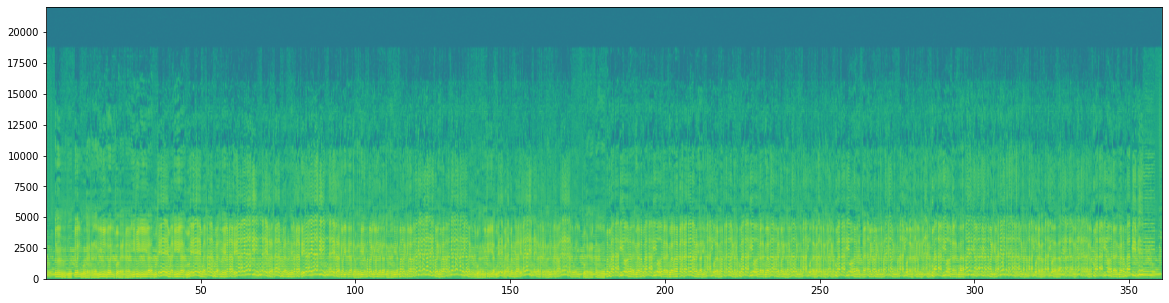

In [6]:
rkm_a = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Audio/223580__gopalkoduri__carnatic-varnam-by-ramakrishnamurthy-in-abhogi-raaga.mp3')

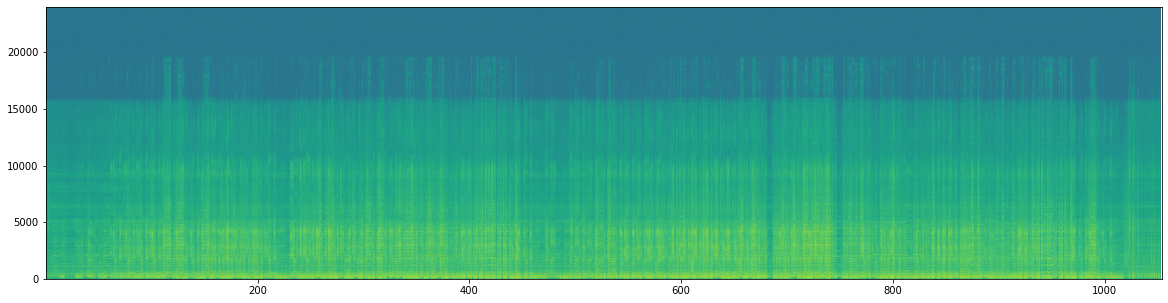

In [7]:
rkm_vishwa=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Ramakrishnan Murthy_ Kriti - Shri Viswanatham Bhajeham ( 256kbps cbr ).mp3')

In [0]:
rkm_a.find_tonic()

In [0]:
test_surabhi = Audio('/content/drive/My Drive/Projects/AA/Music dataset/Raga_Surabhi_3.wav')

In [0]:

cleanedList = [x for x in rkm_a.pitch if (math.isnan(x) == False)]
cleanedList=[round(x,2) for x in cleanedList]
cleanedList

In [0]:
 test_surabhi.cpn.sort()
 print(test_surabhi.cpn)


In [0]:
def tonic_check(testcpn):
  tonic=-1
  tonic_candidates=[]
  testcpn.cpn.sort()
 
  # print(testcpn.cpn)
  sortedcpn= testcpn.cpn[::-1]
  # print(sortedcpn)
  sortedcpn_floored=[]
  for i in range(len(sortedcpn)):
    sortedcpn_floored.append(math.floor(sortedcpn[i]))
  setcpn=list((sortedcpn_floored))
  ratio=12
  min_difference=2
  pos=-1
  for i in range(len(setcpn)):
    for j in range(i,len(setcpn)):
      ratio=(setcpn[i]/setcpn[j])
      difference=abs(ratio-1.5)
      # print(difference)
      if(difference<min_difference and ratio>1.49 and ratio <1.51):
             pos=j
             min_difference=difference
             tonic =sortedcpn[j]
             tonic_candidates.append(sortedcpn[j])
    
  
  print(tonic_candidates)



      
  # print(sortedcpn)
  # for i in ratios:
    # difference.append(absolute(i-1.5))


  # tonic_position= .index(min(a)

  # print(difference.index(min(difference)))
  # print(tonic)


# tonic_check(rkm_a)
# tonic_check(rkm1)
# tonic_check(rkm2)
tonic_check(test_surabhi)
tonic_check(rkm1)
tonic_check(rkm2)



In [0]:
plt.plot(test.pitch)

In [0]:
test.pitch

In [0]:
#checking the ratio of different notes to shadja

# def most_frequent(List): 
#     counter = 0
#     num = List[0] 
      
#     for i in List: 
#         curr_frequency = List.count(i) 
#         if(curr_frequency> counter): 
#             counter = curr_frequency 
#             num = i 
  
#     return num  
def tonic(testo):

  def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num   
  store_tonic_pa=list()
  store_tonic_ri2=list()
  store_tonic_ma1=list()
  store_tonic_ga3=list()
  store_tonic_ni3=list()
  floored=[]
  toniclist=[]
  uniquepitch=set(testo.cpn)
  uniquepitchfloor=[]
  for i in uniquepitch:
    i=math.floor(i)
    uniquepitchfloor.append(i)
  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.49) and ((i/j) <1.51) and j<220):
            
             store_tonic_pa.append(j)
  
  pa_to_sa=most_frequent(store_tonic_pa)
  toniclist.append(pa_to_sa)

  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.1) and ((i/j) <1.14) and j<220):
            
            store_tonic_ri2.append(j)
  
  ri2_to_sa=most_frequent(store_tonic_ri2)
  toniclist.append(ri2_to_sa)

  if(abs(toniclist[1]-toniclist[0])< 5):
    # print(toniclist[0])
    return toniclist[0]


  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.29) and ((i/j) <1.35) and j<220):
           
            store_tonic_ma1.append(j)
  
  ma1_to_sa=most_frequent(store_tonic_ma1)
  toniclist.append(ma1_to_sa)
  
  if((abs(toniclist[2]-toniclist[0])< 5) or (abs(toniclist[2]-toniclist[1])< 5)):
    # print(toniclist[2])
    return toniclist[2]


  
  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.2) and ((i/j) <1.27) and j<220):
            
            store_tonic_ga3.append(j)
  
  ga3_to_sa=most_frequent(store_tonic_ga3)
  toniclist.append(ga3_to_sa)


  if((abs(toniclist[3]-toniclist[0])< 5) or (abs(toniclist[3]-toniclist[1])< 5) or (abs(toniclist[3]-toniclist[2])< 5)):
    # print(toniclist[3])
    return toniclist[3]


  for i in uniquepitchfloor:
    for j in uniquepitchfloor:
          
          if(((i/j)>1.85) and ((i/j) <1.9) and j<220):
            
            store_tonic_ni3.append(j)
  
  ni3_to_sa=most_frequent(store_tonic_ni3)
  toniclist.append(ni3_to_sa)
  
  if((abs(toniclist[4]-toniclist[0])< 5) or (abs(toniclist[4]-toniclist[1])< 5) or (abs(toniclist[4]-toniclist[2])< 5) or (abs(toniclist[4]-toniclist[3])< 5)):
    print(toniclist[4])
    return toniclist[4]
  # print("tonic not found sigh")
  # print(toniclist[0])
  return toniclist[0] #lets just assume Pa was there


#works 

# tonic(test_surabhi)
# tonic(rkm1)
# tonic(rkm2)
tonic(rkm_vishwa)



In [0]:
rkm_vishwa.pitch_contour()

In [0]:
# Now, to test another audio clip
test3=Audio('/content/drive/My Drive/AA/Music dataset/Audio/223586__gopalkoduri__carnatic-varnam-by-badrinarayanan-in-kalyani-raaga.mp3',duration = 40)



In [0]:
plt.plot(test3.pitch)

In [0]:
rkm1=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_1.wav')
rkm2=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_2.wav')


In [0]:
rkm3=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/Raga_Kalyani_0.wav')

In [0]:
tonic(rkm_a)



In [0]:
tonic(rkm2)

In [0]:
#checking out smooth histograms
import seaborn as sns

test2=Audio('/content/drive/My Drive/AA/Music dataset/Raga_Surabhi_3.wav')
free= test.pitch
plt.rcParams['figure.figsize'] = [10, 5]
# sns.set_style('darkgrid')
sns.distplot(free,bins=200)

In [0]:
free2= test2.pitch
plt.rcParams['figure.figsize'] = [10, 5]
# sns.set_style('darkgrid')
sns.distplot(free2,bins=20)

https://pages.mtu.edu/~suits/notefreqs.html

In [0]:
most_frequent([i for i in rkm2.pitch if i>320 and i<325])

In [0]:
#distance metric

import numpy as np
import scipy.stats


def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

# jensen_shannon_distance([1,2,3,4,5],[4,8,12,16,20])

In [0]:
def develop_histogram(a):
  values=[x for x in a.pitch if (math.isnan(x) == False)]
  values=[round(x,0) for x in values]
  occur=dict()
  times=[]
  for i in values:
    if(i in occur):
      occur[i]+=1;
    else:
      occur[i]=1;
  j=50
  while(j<=1000):
    # print(j)
    if(j in occur):
      times.append(occur[j])
    else:
      times.append(0)
    j+=1
  histogram_occurances=times;
  return(times)
  # print(times)
  # print(len(times))



In [0]:
sesha=Audio('/content/drive/My Drive/Projects/AA/Music dataset/Kalyani/kalyani_sesha.mp3')
five=develop_histogram(sesha)

In [0]:
aruna=Audio('/content/drive/My Drive/Projects/AA/Tonic_test/Aruna_170.mp3')
six=develop_histogram(aruna)

In [0]:
one= develop_histogram(rkm1)
two=develop_histogram(rkm2)
three=develop_histogram(rkm3)
four=develop_histogram(rkm_vishwa)

print(len(one))
print(len(two))

In [0]:
jensen_shannon_distance(five,four)